In [8]:
import sys
sys.path.append('../../')

import torch as th
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from lgd.degradations import BlurDegradation
from lgd.optimizers.nonlearnable import TorchGradientOptimizer
from lgd.functions.priors import LpNormPowerPrior, TotalVariationPrior
from lgd.functions.projections import ClampProjection
from lgd.data.datasets import NoiseDatasetWrapper, ShakeBlurDatasetWrapper, BSD500ImagesDataset

DEVICE = 'cuda'

def psnr(x, y):
    se = th.nn.functional.mse_loss(x, y, reduction="none")
    if len(se.shape) == 1:
        mse = se
    else:
        mse = se.mean(dim=list(range(1, len(se.shape))))
    psnr = 10 * th.log10(th.tensor(1 ** 2) / mse)
    return psnr

def crop_for_kernel(imgs, kernel_size):
    shape = (kernel_size, kernel_size)
    p_h = (shape[-2] - 1) // 2
    a_h = (shape[-2] - 1) % 2
    p_w = (shape[-1] - 1) // 2
    a_w = (shape[-1] - 1) % 2

    # extracting the center part
    ret = imgs[..., (p_h + a_h):-p_h, (p_w + a_w):-p_w]
    return ret

# Loading data

In [9]:
dataset = BSD500ImagesDataset('/cache/data/BSD500/images/', train_phase='test',
                                                  max_dataset_length=500,
                                                  out_images_size=128, 
                                                  grayscale_output=False)
dataset = NoiseDatasetWrapper(dataset, min_std=1/255, max_std=5/255)
dataset = ShakeBlurDatasetWrapper(dataset, kernel_size=21)
data = dataset[0]
image = data['image']
kernel = data['kernels']
std = data['noise_std']
image = th.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(device=DEVICE).contiguous()
kernel = th.from_numpy(kernel).unsqueeze(0).to(device=DEVICE).contiguous()

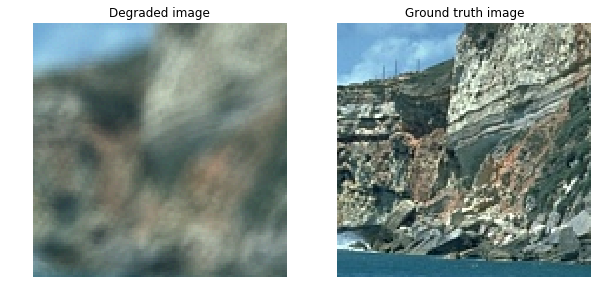

In [11]:
degradation = BlurDegradation(kernel, std, device=DEVICE)
degraded_image = degradation.simulate_degradation(image)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(degraded_image[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');

# Minimizing objective using LBFGS

In [12]:
solver = TorchGradientOptimizer(degradation, 1, TotalVariationPrior(), 3e-4, ClampProjection(0, 1), th.optim.LBFGS,
                                lr=1, max_iter=20, history_size=100, line_search_fn='strong_wolfe')

print('INITIALIZATION: ')
print(f'Likelihood vlaue: {degradation.likelihood(degraded_image, degradation.init_latent_images(degraded_image)).cpu().numpy()}')
print(f'Prior vlaue: {solver.prior(degradation.init_latent_images(degraded_image)).cpu().numpy()}')
restored = th.clamp(solver.restore(degraded_image), 0, 1)
print('AFTER RESTORATION: ')
print(f'Likelihood vlaue: {degradation.likelihood(degraded_image, restored).cpu().numpy()}')
print(f'Prior vlaue: {solver.prior(restored).cpu().numpy()}')

INITIALIZATION: 
Likelihood vlaue: 127.8515396118164
Prior vlaue: 0.3490186035633087
AFTER RESTORATION: 
Likelihood vlaue: 1.0894278287887573
Prior vlaue: 1.6343296766281128


# Visualizing result

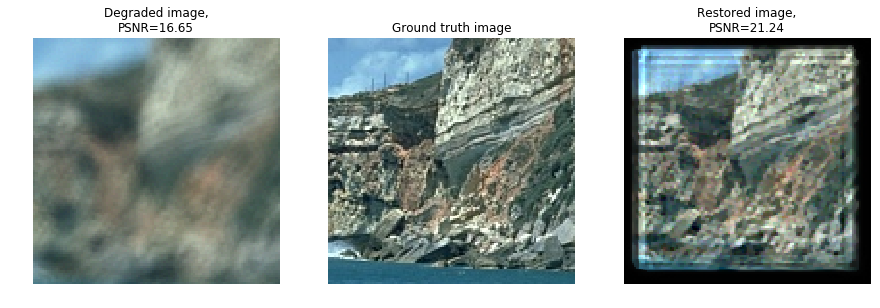

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
psnr_degraded = psnr(degraded_image, crop_for_kernel(image, 21))
ax[0].imshow(degraded_image[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(np.round(psnr_degraded.cpu().numpy(), 2)[0])}')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');
psnr_value = psnr(crop_for_kernel(restored, 21), crop_for_kernel(image, 21))
ax[2].imshow(restored[0].permute(1,2,0).cpu())
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(np.round(psnr_value.cpu().numpy(), 2)[0])}');

# Run grid search to estimate optimal regularizer weight

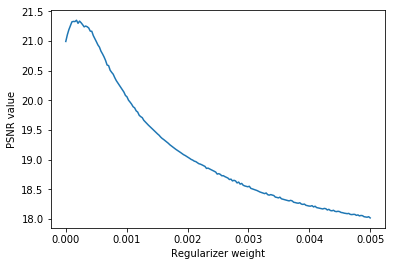

In [16]:
def grid_search(degraded_image, ground_truth_image, degradation, max_value=1e-3, num_points=100):
    candidates = np.linspace(0, max_value, num=num_points)
    psnrs = []
    for candidate in candidates:
        solver = TorchGradientOptimizer(degradation, 1, TotalVariationPrior(), candidate, ClampProjection(0, 1), th.optim.LBFGS,
                                        lr=1, max_iter=20, history_size=100, line_search_fn='strong_wolfe')
        restored = th.clamp(solver.restore(degraded_image), 0, 1)
        psnrs.append(psnr(crop_for_kernel(restored, 21), crop_for_kernel(ground_truth_image, 21)).cpu().numpy())
    return candidates[np.argmax(psnrs)], candidates, psnrs

optimal_weight, candidates, psnrs_hist  = grid_search(degraded_image, image, degradation, max_value=5e-3, num_points=200)
plt.plot(candidates, psnrs_hist)
plt.xlabel('Regularizer weight')
plt.ylabel('PSNR value');

# Run restoration with optimal weight

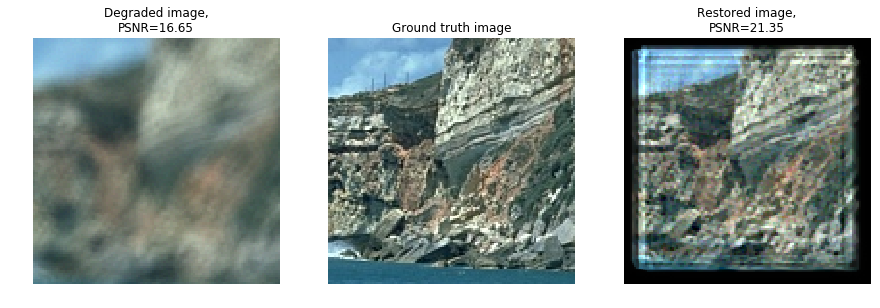

In [17]:
solver = TorchGradientOptimizer(degradation, 1, TotalVariationPrior(), optimal_weight, ClampProjection(0, 1), th.optim.LBFGS,
                                lr=1, max_iter=20, history_size=100, line_search_fn='strong_wolfe')
restored = th.clamp(solver.restore(degraded_image), 0, 1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
psnr_degraded = psnr(degraded_image, crop_for_kernel(image, 21))
ax[0].imshow(degraded_image[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(np.round(psnr_degraded.cpu().numpy(), 2)[0])}')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');
psnr_value = psnr(crop_for_kernel(restored, 21), crop_for_kernel(image, 21))
ax[2].imshow(restored[0].permute(1,2,0).cpu())
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(np.round(psnr_value.cpu().numpy(), 2)[0])}');